<a href="https://colab.research.google.com/github/abdulwasaeee/reinforcement-learning-course/blob/main/deep-q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import time

import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
id= "CartPole-v1"
n=1
timesteps=100000
learningrate= 2e-3
buffersize=10000
gamma=0.99
tau=1.0
tnfreq= 50  #target netwrok update
batchsize= 32
starteps= 1
endeps= 0.01
te= 10000   #decrease from starteps to endeps
stepsbeforetraining= 5000
trainfreq= 4

seed=None
path= "videos"


In [ ]:
def make_env(id, video, seed=None):
  if video:
    env= gym.make(id, render_mode="rgb_array")
    env= gym.wrappers.RecordVideo(env, path, episode_trigger= lambda episode: True, fps=30)

  else:
    env= gym.make(id)
  env= gym.wrappers.RecordEpisodeStatistics(env)

  if seed is not None:
    env.action_space(seed)
  return env

In [ ]:
class QN(nn.Module):
  def __init__(self, envs, hidden=128):
    super().__init__()
    self.network= nn.Sequential(
        nn.Linear(np.array(envs.single_observation_space.shape).prod(), hidden),
        nn.ReLU(),
        nn.Linear(hidden, envs.single_action_space.n)
    )

  def forward(self,x):
    return self.network(x)

In [ ]:
def linear_schedule(starteps, endeps, duration, t):
  slope= (endeps- starteps)/ duration
  return max(slope*t + starteps, endeps)

In [ ]:
envs= gym.vector.SyncVectorEnv([
    lambda: make_env(
        id,
        video= False,
        seed=seed if seed is None else seed + i)
    for i in range(n)
])

In [ ]:
device= torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [ ]:
qn= QN(envs).to(device)
tqn= QN(envs).to(device)
opt= torch.optim.Adam(qn.parameters(), lr=learningrate)
tqn.load_state_dict(qn.state_dict())

<All keys matched successfully>

In [ ]:
class ReplayBuffer:
  def __init__(self,obsdim,size):
    self.obs1_buf= np.zeros([size,obsdim], dtype=np.float32)
    self.obs2_buf= np.zeros([size,obsdim], dtype=np.float32)
    self.actions_buf= np.zeros(size, dtype=np.uint8)
    self.rewards_buf= np.zeros(size, dtype=np.float32)
    self.terminateds_buf= np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.maxsize= 0, 0, size

  def store(self, s, a, r, s2, term):
    self.obs1_buf[self.ptr]= s
    self.obs2_buf[self.ptr]= s2
    self.actions_buf[self.ptr]= a
    self.rewards_buf[self.ptr]= r
    self.terminateds_buf[self.ptr]= term
    self.ptr= (self.ptr+1) % self.maxsize
    self.size= min(self.size+1, self.maxsize)

  def samplebatch(self, batchsize=32):
    idxs= np.random.randint(0, self.size, size=batchsize)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.actions_buf[idxs],
                r=self.rewards_buf[idxs],
                d=self.terminateds_buf[idxs]

    )


In [ ]:
rb= ReplayBuffer(envs.single_observation_space.shape[0], buffersize)

In [ ]:
def n2t(a, tofloat=True):
  if tofloat:
    dtype= torch.float32
  else:
    dtype= torch.int64
  return torch.as_tensor(a, dtype=dtype, device= device)


In [ ]:
epreturns= []
losses= []

start=time.time()
obs, _ = envs.reset(seed=seed)
autoreset= np.zeros(n, dtype=bool)

for globalstep in range(timesteps):
  eps= linear_schedule(starteps, endeps, te, globalstep)
  if random.random() < eps:
    actions= np.array(
        [envs.single_action_space.sample() for _ in range(n)]
    )
  else:
    qvalues= qn(n2t(obs))
    actions= torch.argmax(qvalues, dim=1).cpu().numpy()

  nextobs, rewards, terminateds, truncateds, infos= envs.step(actions)

  for i, (terminated,truncated) in enumerate(zip(terminateds,truncateds)):
       if terminated or truncated:
          ret= infos['episode']['r'][i]
          epreturns.append(ret)
          print(f"global step= {globalstep}, episode={len(epreturns)}, episode returns= {ret}")
  for i in range(n):
    if not autoreset[i]:
      rb.store(obs[i], actions[i], rewards[i], nextobs[i], terminateds[i])

  obs=nextobs
  autoreset=np.logical_or(terminateds, truncateds)

  if globalstep > stepsbeforetraining:
     if globalstep%trainfreq==0:
      batch= rb.samplebatch(batchsize)
      with torch.no_grad():
        qmax, _= tqn(n2t(batch["s2"])).max(dim=1)
        target= n2t(batch["r"].flatten()) + gamma* n2t(1-batch["d"].flatten()) * qmax
      a= n2t(batch['a'], tofloat=False)
      a= a.reshape(-1,1)
      s= n2t(batch["s"])
      qsa= qn(s)
      pred=qsa.gather(1,a).squeeze()
      loss= torch.nn.functional.mse_loss(target.squeeze(), pred.squeeze())
      losses.append(loss.detach().cpu().numpy())
      opt.zero_grad()
      loss.backward()
      opt.step()


  if globalstep% 1000 ==0:
    print("steps per second:", int(globalstep/ (time.time()- start)))

  if globalstep% tnfreq==0:
      for tqnparam, qnparam in zip(tqn.parameters(), qn.parameters()):
        tqnparam.data.copy_( tau* qnparam.data + (1-tau)* tqnparam.data)

  if len(epreturns)>10 and np.all(np.equal(epreturns[-10:], 500)):
    print("max reward acheived")
    break


steps per second: 0
global step= 22, episode=1, episode returns= 23.0
global step= 53, episode=2, episode returns= 30.0
global step= 69, episode=3, episode returns= 15.0
global step= 107, episode=4, episode returns= 37.0
global step= 150, episode=5, episode returns= 42.0
global step= 168, episode=6, episode returns= 17.0
global step= 187, episode=7, episode returns= 18.0
global step= 210, episode=8, episode returns= 22.0
global step= 232, episode=9, episode returns= 21.0
global step= 299, episode=10, episode returns= 66.0
global step= 311, episode=11, episode returns= 11.0
global step= 338, episode=12, episode returns= 26.0
global step= 350, episode=13, episode returns= 11.0
global step= 372, episode=14, episode returns= 21.0
global step= 392, episode=15, episode returns= 19.0
global step= 428, episode=16, episode returns= 35.0
global step= 451, episode=17, episode returns= 22.0
global step= 471, episode=18, episode returns= 19.0
global step= 486, episode=19, episode returns= 14.0
glob

In [ ]:
envs.close()

In [ ]:
def smooth(x, a=0.1):
  y=[x[0]]
  for xi in x[1:]:
    yi= a* xi + (1-a) * y[-1]
    y.append(yi)
  return y

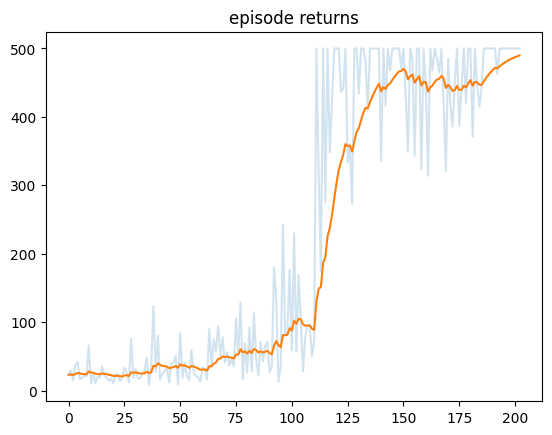

In [ ]:
plt.plot(epreturns, alpha=0.2)
plt.plot(smooth(epreturns))
plt.title("episode returns")
plt.show()

In [ ]:
!rm -rf videos

Text(0.5, 1.0, 'losses')

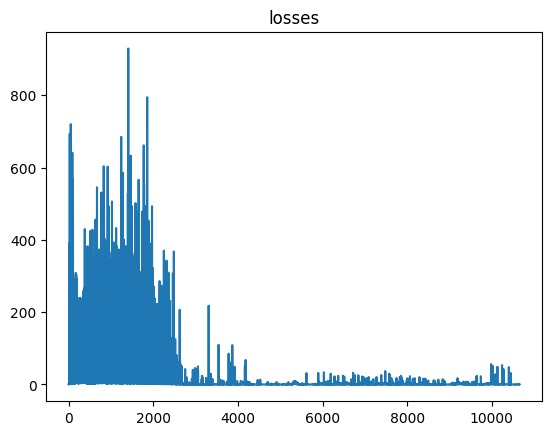

In [ ]:
plt.plot(losses)
plt.title("losses")

In [ ]:
modelpath= "dqn.pth"
torch.save(qn.state_dict(), modelpath)

In [ ]:
evalenv= gym.vector.SyncVectorEnv([lambda: make_env(id, True)])
model= QN(evalenv).to(device) # Correctly initialize a new QN model for evaluation
model.load_state_dict(torch.load(modelpath))

<All keys matched successfully>

In [ ]:
model.eval()

QN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
evalreturns= np.zeros(10)
obs,_ = evalenv.reset()

for i in range(10):
  epdone=False
  while not epdone:
    qvalues= model(n2t(obs))
    actions= torch.argmax(qvalues, dim=1).cpu().numpy()
    nextobs, rewards, terminateds, truncateds, infos= evalenv.step(actions)
    obs=nextobs
    if terminateds[0] or truncateds[0]:
      G=infos["episode"]["r"][0]
      evalreturns[i]= G
      print(f"episode: {i} return: {G}")
      epdone=True

envs.close()


episode: 0 return: 500.0
episode: 1 return: 500.0
episode: 2 return: 465.0
episode: 3 return: 500.0
episode: 4 return: 386.0
episode: 5 return: 387.0
episode: 6 return: 386.0
episode: 7 return: 500.0
episode: 8 return: 406.0
episode: 9 return: 500.0


In [ ]:
from IPython.display import Video
Video("videos/rl-video-episode-99.mp4",embed=True)